# Importing libraries

In [183]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.optim import SGD, Adam, lr_scheduler
from copy import deepcopy

In [184]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Downloading and loading dataset

In [185]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

train, val = random_split(train, [45000, 5000], generator = torch.manual_seed(0))

train_loader = torch.utils.data.DataLoader(train, batch_size=64,
                                          shuffle=False, num_workers=2)

val_loader = torch.utils.data.DataLoader(val, batch_size=64,
                                          shuffle=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(test, batch_size=64,
                                         shuffle=False, num_workers=2)

classes_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

size_train = len(train)
size_val = len(val)
size_test = len(test)

Files already downloaded and verified
Files already downloaded and verified


# Exploring dataset

In [186]:
data_iterator = iter(train_loader)
images, classes = data_iterator.next()

In [187]:
images[0].shape

torch.Size([3, 32, 32])

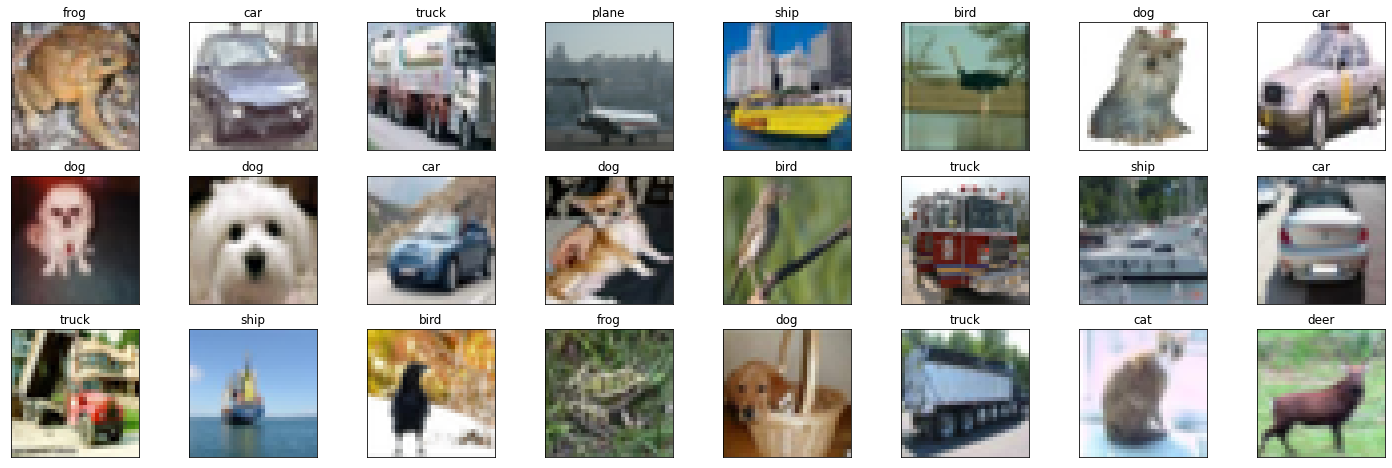

In [188]:
fig = plt.figure(figsize=(25, 8))

def show_image(image):
    image = image / 2 + 0.5
    image = image.numpy()
    plt.imshow(np.transpose(image, (1, 2, 0)))

n_row = 3
batch_size = 8

for row_idx in np.arange(n_row):
    images, classes = data_iterator.next()
    for idx in np.arange(batch_size):
      ax = fig.add_subplot(n_row, batch_size, batch_size*row_idx+idx+1, xticks=[], yticks=[])
      show_image(images[idx])
      ax.set_title(classes_names[classes[idx]])

# Simple CNN model with SGD optimizer

In [189]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 9, 3)
        self.fc1 = nn.Linear(9 * 6 * 6, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 9 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [190]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)

In [191]:
best_accuracy = -1
best_model = None
model.train_loss = list()
model.train_accuracy = list()
model.val_accuracy = list()

for epoch in range(40):

    training_loss = 0
    training_correct = 0

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item() * inputs.size(0)
        predicted = torch.argmax(outputs.detach(), dim=1)
        training_correct += (predicted == labels).sum().item()
    
    training_loss = training_loss/size_train
    training_accuracy = training_correct*100/size_train

    model.train_loss.append(training_loss)
    model.train_accuracy.append(training_accuracy)

    print(f"Epoch {epoch+1}")
    print(f"Training loss: {training_loss}")
    print(f"Training accuracy: {training_accuracy}%")
    
    validation_correct = 0
    with torch.no_grad():
        for inputs,labels in val_loader:
            outputs = model(inputs.to(device)).cpu()
            predicted = torch.argmax(outputs.detach(), dim=1)
            validation_correct += (predicted == labels).sum().item()
    
    val_accuracy = validation_correct*100/size_val
    model.val_accuracy.append(val_accuracy)

    print(f"Validation accuracy: {val_accuracy}%")

    if validation_correct > best_accuracy:
        best_accuracy = validation_correct
        best_model = deepcopy(model.state_dict())
      
    print('-'*30)

print('Finished Training')

Epoch 1
Training loss: 2.3034703648037382
Training accuracy: 10.075555555555555%
Validation accuracy: 9.32%
------------------------------
Epoch 2
Training loss: 2.299122272576226
Training accuracy: 10.568888888888889%
Validation accuracy: 10.3%
------------------------------
Epoch 3
Training loss: 2.2667284862094457
Training accuracy: 17.342222222222222%
Validation accuracy: 20.4%
------------------------------
Epoch 4
Training loss: 2.059021082221137
Training accuracy: 25.68888888888889%
Validation accuracy: 28.6%
------------------------------
Epoch 5
Training loss: 1.9340124612172445
Training accuracy: 30.58888888888889%
Validation accuracy: 32.8%
------------------------------
Epoch 6
Training loss: 1.8109188131968181
Training accuracy: 34.86666666666667%
Validation accuracy: 36.9%
------------------------------
Epoch 7
Training loss: 1.69309783905877
Training accuracy: 38.93555555555555%
Validation accuracy: 40.4%
------------------------------
Epoch 8
Training loss: 1.6046841519

In [192]:
model.load_state_dict(best_model)

test_correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(device)).cpu()
        predicted = torch.argmax(outputs, dim=1)
        test_correct += (predicted == labels).sum().item()

print(f"Test accuracy: {test_correct*100/size_test}%")

Test accuracy: 56.5%


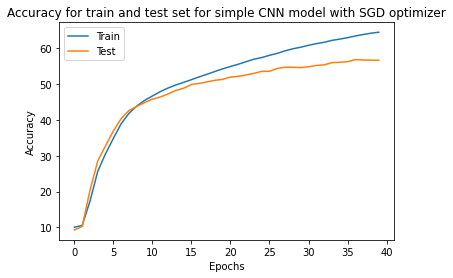

In [193]:
plt.figure()
plt.plot([i for i in range(40)], model.train_accuracy)
plt.plot([i for i in range(40)], model.val_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.title('Accuracy for train and test set for simple CNN model with SGD optimizer')
plt.show()

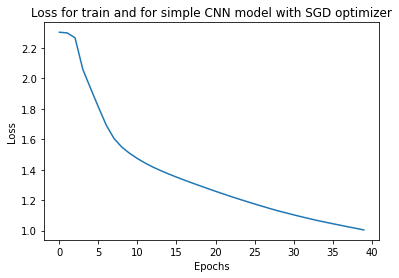

In [194]:
plt.figure()
plt.plot([i for i in range(40)], model.train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for train and for simple CNN model with SGD optimizer')
plt.show()

# Simple CNN model with Adam optimizer

In [195]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

train, val = random_split(train, [45000, 5000], generator = torch.manual_seed(0))

train_loader = torch.utils.data.DataLoader(train, batch_size=64,
                                          shuffle=False, num_workers=2)

val_loader = torch.utils.data.DataLoader(val, batch_size=64,
                                          shuffle=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(test, batch_size=64,
                                         shuffle=False, num_workers=2)

classes_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

size_train = len(train)
size_val = len(val)
size_test = len(test)

Files already downloaded and verified
Files already downloaded and verified


In [196]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 9, 3)
        self.fc1 = nn.Linear(9 * 6 * 6, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 9 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [197]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [198]:
best_accuracy = -1
best_model = None
model.train_loss = list()
model.train_accuracy = list()
model.val_accuracy = list()

for epoch in range(40):

    training_loss = 0
    training_correct = 0

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item() * inputs.size(0)
        predicted = torch.argmax(outputs.detach(), dim=1)
        training_correct += (predicted == labels).sum().item()
    
    training_loss = training_loss/size_train
    training_accuracy = training_correct*100/size_train

    model.train_loss.append(training_loss)
    model.train_accuracy.append(training_accuracy)

    print(f"Epoch {epoch+1}")
    print(f"Training loss: {training_loss}")
    print(f"Training accuracy: {training_accuracy}%")
    
    validation_correct = 0
    with torch.no_grad():
        for inputs,labels in val_loader:
            outputs = model(inputs.to(device)).cpu()
            predicted = torch.argmax(outputs.detach(), dim=1)
            validation_correct += (predicted == labels).sum().item()
    
    val_accuracy = validation_correct*100/size_val
    model.val_accuracy.append(val_accuracy)

    print(f"Validation accuracy: {val_accuracy}%")

    if validation_correct > best_accuracy:
        best_accuracy = validation_correct
        best_model = deepcopy(model.state_dict())
      
    print('-'*30)

print('Finished Training')

Epoch 1
Training loss: 1.7628333606931899
Training accuracy: 35.30222222222222%
Validation accuracy: 40.78%
------------------------------
Epoch 2
Training loss: 1.475157721371121
Training accuracy: 46.29333333333334%
Validation accuracy: 45.3%
------------------------------
Epoch 3
Training loss: 1.3737185355504353
Training accuracy: 50.33111111111111%
Validation accuracy: 48.28%
------------------------------
Epoch 4
Training loss: 1.3010576575173272
Training accuracy: 53.10666666666667%
Validation accuracy: 50.54%
------------------------------
Epoch 5
Training loss: 1.241859895790948
Training accuracy: 55.34%
Validation accuracy: 52.14%
------------------------------
Epoch 6
Training loss: 1.1913671242607964
Training accuracy: 57.32888888888889%
Validation accuracy: 53.34%
------------------------------
Epoch 7
Training loss: 1.1492044195916917
Training accuracy: 58.977777777777774%
Validation accuracy: 54.88%
------------------------------
Epoch 8
Training loss: 1.1142379304779901

In [199]:
model.load_state_dict(best_model)

test_correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(device)).cpu()
        predicted = torch.argmax(outputs, dim=1)
        test_correct += (predicted == labels).sum().item()

print(f"Test accuracy: {test_correct*100/size_test}%")

Test accuracy: 58.27%


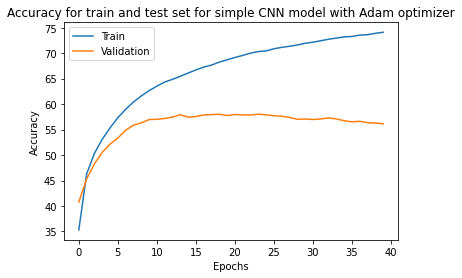

In [200]:
plt.figure()
plt.plot([i for i in range(40)], model.train_accuracy)
plt.plot([i for i in range(40)], model.val_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Accuracy for train and test set for simple CNN model with Adam optimizer')
plt.show()

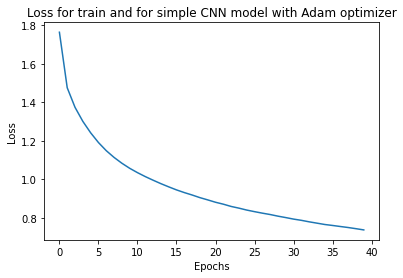

In [201]:
plt.figure()
plt.plot([i for i in range(40)], model.train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for train and for simple CNN model with Adam optimizer')
plt.show()

# Simple CNN model with Adam optimizer and simple data augmentation

In [202]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

train, val = random_split(train, [45000, 5000], generator = torch.manual_seed(0))

train_loader = torch.utils.data.DataLoader(train, batch_size=64,
                                          shuffle=False, num_workers=2)

val_loader = torch.utils.data.DataLoader(val, batch_size=64,
                                          shuffle=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(test, batch_size=64,
                                         shuffle=False, num_workers=2)

classes_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

size_train = len(train)
size_val = len(val)
size_test = len(test)

Files already downloaded and verified
Files already downloaded and verified


In [203]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 9, 3)
        self.fc1 = nn.Linear(9 * 6 * 6, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 9 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [204]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [205]:
best_accuracy = -1
best_model = None
model.train_loss = list()
model.train_accuracy = list()
model.val_accuracy = list()

for epoch in range(40):

    training_loss = 0
    training_correct = 0

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item() * inputs.size(0)
        predicted = torch.argmax(outputs.detach(), dim=1)
        training_correct += (predicted == labels).sum().item()
    
    training_loss = training_loss/size_train
    training_accuracy = training_correct*100/size_train

    model.train_loss.append(training_loss)
    model.train_accuracy.append(training_accuracy)

    print(f"Epoch {epoch+1}")
    print(f"Training loss: {training_loss}")
    print(f"Training accuracy: {training_accuracy}%")
    
    validation_correct = 0
    with torch.no_grad():
        for inputs,labels in val_loader:
            outputs = model(inputs.to(device)).cpu()
            predicted = torch.argmax(outputs.detach(), dim=1)
            validation_correct += (predicted == labels).sum().item()
    
    val_accuracy = validation_correct*100/size_val
    model.val_accuracy.append(val_accuracy)

    print(f"Validation accuracy: {val_accuracy}%")

    if validation_correct > best_accuracy:
        best_accuracy = validation_correct
        best_model = deepcopy(model.state_dict())
      
    print('-'*30)

print('Finished Training')

Epoch 1
Training loss: 1.8260866643481783
Training accuracy: 32.92888888888889%
Validation accuracy: 38.52%
------------------------------
Epoch 2
Training loss: 1.5748945922427706
Training accuracy: 42.708888888888886%
Validation accuracy: 41.94%
------------------------------
Epoch 3
Training loss: 1.5036772079043919
Training accuracy: 45.42%
Validation accuracy: 44.58%
------------------------------
Epoch 4
Training loss: 1.4625870570924546
Training accuracy: 47.37111111111111%
Validation accuracy: 46.02%
------------------------------
Epoch 5
Training loss: 1.431464433394538
Training accuracy: 48.553333333333335%
Validation accuracy: 47.42%
------------------------------
Epoch 6
Training loss: 1.4042605703141955
Training accuracy: 49.40888888888889%
Validation accuracy: 47.66%
------------------------------
Epoch 7
Training loss: 1.3828814354366725
Training accuracy: 50.19555555555556%
Validation accuracy: 48.54%
------------------------------
Epoch 8
Training loss: 1.3639102943844

In [206]:
model.load_state_dict(best_model)

test_correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(device)).cpu()
        predicted = torch.argmax(outputs, dim=1)
        test_correct += (predicted == labels).sum().item()

print(f"Test accuracy: {test_correct*100/size_test}%")

Test accuracy: 58.69%


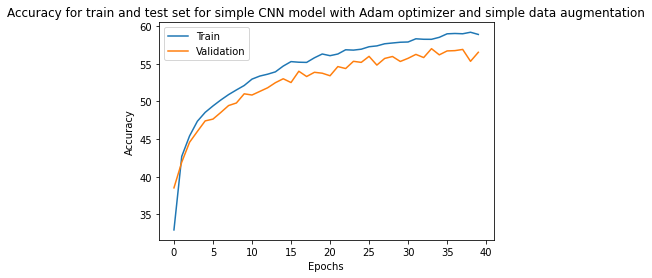

In [207]:
plt.figure()
plt.plot([i for i in range(40)], model.train_accuracy)
plt.plot([i for i in range(40)], model.val_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Accuracy for train and test set for simple CNN model with Adam optimizer and simple data augmentation')
plt.show()

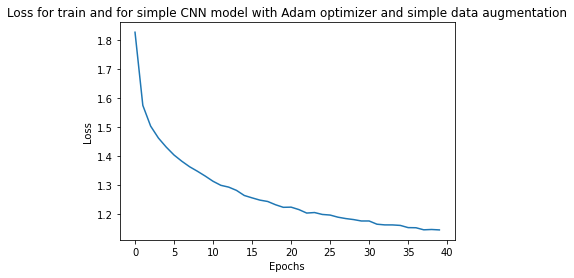

In [208]:
plt.figure()
plt.plot([i for i in range(40)], model.train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for train and for simple CNN model with Adam optimizer and simple data augmentation')
plt.show()